# Note

This repository is built with the intention of reproducible science - you can viewing a copy of the data used, all the results - plots, tables and notebooks. However, you can also run everything from scratch, and generate the results yourself.

So, if you would like to delete all results generated by the authors, and re-run everything to download the data, extract all features and run the models, and generate all plots, please do the following:

Delete the directories:
- ```data/```
- ```results/```

# 1. Download Chen et. al's catalog from Zenodo

In [44]:
import os
import requests
import wget
import tqdm
import zipfile
import sys
import numpy as np
import pandas as pd
import subprocess
from tqdm.auto import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

import sys
# import os
# from pathlib import Path

sys.path.append("scripts/")

import utils

import json
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [2]:
if not os.path.exists("data/Table2.txt"):
    print("Downloading Chen et. al's table from Zenodo")

    url = "https://zenodo.org/records/3886372/files/Table2.txt.zip"
    response = requests.get(url, stream=True)

    total_size_in_bytes = int(response.headers.get("content-length", 0))
    block_size = 1024  # 1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)

    with open("data/Table2.txt.zip", "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

    zip_path = "data/Table2.txt.zip"
    extract_path = "data/"

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Unzipped the file successfully.")

    os.remove(zip_path)
    print("Deleted the zip file.")

else:
    print("File already exists: data/Table2.txt")

File already exists: data/Table2.txt


# 2. Choose objects

In [3]:
chen_cols = ["ID", "SourceID", "RAdeg", "DEdeg", "Per", "R21", "phi21",
             "T_0", "gmag", "rmag", "Per_g", "Per_r", "Num_g", "Num_r",
             "R21_g", "R21_r", "phi21_g", "phi21_r", "R^2_g", "R^2_r",
             "Amp_g", "Amp_r", "log(FAP_g)", "log(FAP_r)", "Type",
             "213-elta_min_g", "219-elta_min_r"]

chenfeatures_df = pd.read_table("data/Table2.txt",
                            sep = " ", header=None,
                            skipinitialspace=True, skiprows=34,
                            names=chen_cols, index_col=1)

chenfeatures_df = chenfeatures_df.dropna()

chenfeatures_df = chenfeatures_df.drop([
        # Irrelevant:
        "ID", "RAdeg", "DEdeg", "T_0", "Num_g", "Num_r",
        # Redundant:
        "Per", "Per_g", "Per_r",
        "rmag", "gmag", 
        "Amp_g", "Amp_r",
        "phi21",
        "R21"
    ], axis=1)

class_df = chenfeatures_df[["Type"]]
chenfeatures_df = chenfeatures_df.drop(["Type"],axis=1)


In [4]:
class_df.value_counts()

Type 
EW       369707
SR       119261
BYDra     84697
RSCVN     81393
EA        49943
RR        32518
DSCT      16709
RRc       13875
Mira      11879
CEP        1262
CEPII       358
Name: count, dtype: int64

In [5]:
all_classes = ["RSCVN", "BYDra", "DSCT", "EA", "EW", "RRc", "RR", "SR", "CEP", "Mira"]
class_df = class_df[class_df["Type"].isin(all_classes)]
class_df = (class_df
            .groupby('Type', group_keys=True)
            .apply(lambda x: x.sample(n=1200), include_groups=False)
            .reset_index()
            .set_index("SourceID")
           )

chenfeatures_df = chenfeatures_df.loc[class_df.index]

In [6]:
class_df.value_counts()

Type 
BYDra    1200
CEP      1200
DSCT     1200
EA       1200
EW       1200
Mira     1200
RR       1200
RRc      1200
RSCVN    1200
SR       1200
Name: count, dtype: int64

##### Refer to the following for help in writing MD explanations.
- https://github.com/AshishMahabal/LCDistanceMetrics/blob/22feb/siddharth/03%20-%20Distance%20calculation/distance%20analysis.ipynb


In [9]:
metric = "cityblock"
metric_str = utils.get_metric_name(metric)

In [10]:
obj = lc_distance.LightCurveDistanceAnalysis(input_feature_df=alercefeatures_df, # chenalerce_df
                          class_df=class_df,
                          classes_to_keep=['CEP'],
                          n_samples=713,
                          dist_metric="cityblock")

# chenfeatures_df = chenfeatures_df.sort_values(by=['Type'])

NameError: name 'lc_distance' is not defined

In [11]:
feature_arr = chenfeatures_df.to_numpy()
class_arr = class_df.to_numpy().ravel()
oids = chenfeatures_df.index.to_numpy()
dist_list = distance.pdist(feature_arr, metric)
# Note: Since dist(a,b) = dist(b,a), we calculate pdist then square form to get redundant square distance matrix
# Else, we'd have calculated cdist and then used square_form to get the condensed distance matrix
dist_sqform = distance.squareform(dist_list)

In [12]:
a_name_list = []
b_name_list = []
a_class_list = []
b_class_list = []


for i in tqdm(range(len(feature_arr))):
    a_name = oids[i]
    a_class = class_arr[i]
    for j in range(i+1,len(feature_arr)):
        b_name = oids[j]
        b_class = class_arr[j]

        a_name_list.append(a_name)
        b_name_list.append(b_name)
        a_class_list.append(a_class)
        b_class_list.append(b_class)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [13]:
dist_list = np.array(dist_list).reshape(-1,1)
a_name_list = np.array(a_name_list).reshape(-1,1)
b_name_list = np.array(b_name_list).reshape(-1,1)
a_class_list = np.array(a_class_list).reshape(-1,1)
b_class_list = np.array(b_class_list).reshape(-1,1)

In [14]:
dist_df = pd.DataFrame(data=dist_list, columns=[metric_str])
dist_df["a_id"] = a_name_list
dist_df["b_id"] = b_name_list
dist_df["a_class"] = a_class_list
dist_df["b_class"] = b_class_list

In [15]:
dist_df = dist_df[dist_df["a_id"]!=dist_df["b_id"]].reset_index(drop=True)

In [16]:
dist_df["ab_class_identifier"] = dist_df["a_class"]+"-"+dist_df["b_class"]

In [17]:
assert dist_df["a_class"].unique().shape == dist_df["b_class"].unique().shape

In [18]:
n_class = len(dist_df["a_class"].unique())
n_combinations = len(dist_df["ab_class_identifier"].unique())

In [19]:
import math
assert n_combinations == (math.comb(n_class,2)+n_class)

In [20]:
plot_elem = "bars"
plot_fill = False
logx = False

<Axes: xlabel='Cityblock', ylabel='Count'>

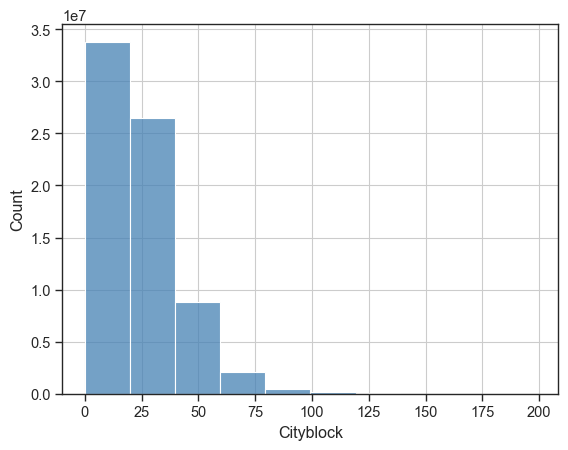

In [21]:
sns.histplot(data=dist_df, x=metric_str,color="SteelBlue",
             label="CEP-CEP", 
             #ax=ax2, 
             bins=10, 
             log_scale=[logx, False], 
             element=plot_elem, 
             fill=True
            )

In [22]:
# fig, (ax1,ax2) = plt.subplots(2, sharex=True,
#                               gridspec_kw={"height_ratios": (.15, .85)})
# sns.boxplot(data=dist_df, x=metric_str, ax=ax1,color="SteelBlue", 
#             whis=(10,90)
#            )
# sns.histplot(data=dist_df, x=metric_str,color="SteelBlue",label="CEP-CEP", ax=ax2, bins=10, log_scale=[logx, False], element=plot_elem, fill=True)

# ax1.set_title("Pairwise distance between CEPs (before dropping outliers)")
# ax1.set(xlabel=metric_str)


# ax2.set_yscale("log")

# x_ls = [l.get_text() for l in ax2.get_xticklabels()]


# ax3 = plt.axes([0.5, 0.3, 0.35, 0.35])
# sns.histplot(data=dist_df[dist_df[metric_str]<1e9], x=metric_str,color="SteelBlue",label="CEP-CEP", bins=20, ax=ax3, log_scale=[logx, False], element=plot_elem, fill=True
#         )
# ax3.set_xlabel(None)
# ax3.set_ylabel(None)
# ax3.set_yscale("log")

# ax2.grid()
# ax3.grid()


# l1 = ax2.get_xticklabels()

# ax2.set_xticklabels(['$-2.5 \\times 10^{8}$',
#  '$0.0$',
#  '$2.5 \\times 10^{8}$',
#  '$5 \\times 10^{8}$',
#  '$7.5 \\times 10^{8}$',
#  '$1 \\times 10^{9}$',
#  '$1.25 \\times 10^{9}$',
#  '$1.5 \\times 10^{9}$',
#                     ], rotation=-45+360, ha="center")

# ax3.set_xticks(ticks=[0, 1e6, 2e6],
#                labels=[ '$0$',
#  '$1 \\times 10^{6}$',
#  '$2 \\times 10^{6}$'],)







# ax2.set_xlabel(f"{metric_str} distance")

# # plt.savefig("../../phoenix/CEP_Before.png",dpi=300, bbox_inches="tight")


### DROP OUTLIERS

In [30]:
percent_drop_low = 10
percent_drop_high = 10

In [33]:
d = dist_df[dist_df["a_class"] == dist_df["b_class"]]

In [34]:
outlierdf_list = []

In [36]:
method = "mean"

In [38]:
for cur_class in tqdm(all_classes):
    subdf = d[d["ab_class_identifier"] == f"{cur_class}-{cur_class}"]
    all_ids = np.unique(np.concatenate([subdf["a_id"].unique(),subdf["b_id"].unique()]))
    id_dist_list = []
    for id_of_interest in all_ids:
        id_df = d[(d["a_id"]==id_of_interest)| (d["b_id"]==id_of_interest)]
        if method=="median":
            id_dist_list.append(id_df[metric_str].median())
        elif method=="mean":
            id_dist_list.append(id_df[metric_str].mean())
    newdf = pd.DataFrame(data=np.column_stack((all_ids,id_dist_list)),columns=["obj_id",f"{method}_dist"])
    newdf["obj_id"] = newdf["obj_id"].astype(int)
    newdf["class"] = cur_class

    cutoff_low = (percent_drop_low*len(newdf) //100)
    cutoff_high = (percent_drop_high*len(newdf) //100)

    throwdf_low = newdf.sort_values(f"{method}_dist").reset_index(drop=True)[:cutoff_low]
    throwdf_low = throwdf_low.reset_index(drop=True).set_index("obj_id")
    throwdf_low["end"] = "lower"

    throwdf_high = newdf.sort_values(f"{method}_dist").reset_index(drop=True)[-cutoff_high:]
    throwdf_high = throwdf_high.reset_index(drop=True).set_index("obj_id")
    throwdf_high["end"] = "upper"

    outlierdf_list.append(throwdf_low)
    outlierdf_list.append(throwdf_high)

outliers_df = pd.concat(outlierdf_list)

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
# Drop all rows whose either a_id or b_id is in outlier
dist_df = dist_df[
    (~dist_df["a_id"].isin(outliers_df.index.to_numpy()))
    &
    (~dist_df["b_id"].isin(outliers_df.index.to_numpy()))
]

In [40]:
dist_df = dist_df.reset_index(drop=True)

In [41]:
undropped_ids = np.unique(np.concatenate([dist_df["a_id"].unique(),dist_df["b_id"].unique()]))

In [42]:
chenfeatures_df = chenfeatures_df.loc[undropped_ids]

<Axes: xlabel='Cityblock', ylabel='Count'>

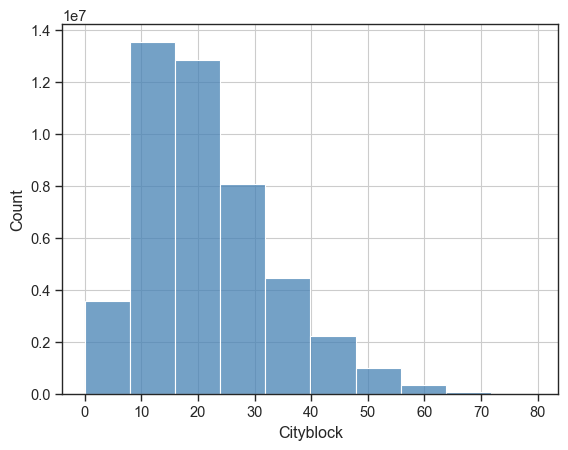

In [43]:
sns.histplot(data=dist_df, x=metric_str,color="SteelBlue",
             label="CEP-CEP", 
             #ax=ax2, 
             bins=10, 
             log_scale=[logx, False], 
             element=plot_elem, 
             fill=True
            )

# 3. Download light curves for objects in Chen et al's catalog

### INCOMPLETE

Refer to ```phoenix/ztf_download/hidden_data_multiclass/``` and convert the 5 notebooks/py to a single notebook below. 

# 4. Extract features with Alerce Package

---

Finally, we are left with:
- ```data/X_df.csv```
- ```data/HIDDENX_df_binary.csv```
- ```data/HIDDENX_df_multiclass.csv```
- ```data/HIDDENX_df_ovr.csv```
- ```data/y_df.csv```
- ```data/HIDDENy_df_binary.csv```
- ```data/HIDDENy_df_multiclass.csv```
- ```data/HIDDENy_df_ovr.csv```
